In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn
import scipy
from sklearn.metrics import classification_report , accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42
LABELS = ["Normal","Fraud"]
warnings.filterwarnings('ignore')


# Loading the dataset

In [6]:
data=pd.read_csv('creditcard.csv')

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [21]:
fraud = data[data['Class']==1]
Valid = data[data['Class']==0]

outlier_fraction = len(fraud)/float(len(Valid))

In [23]:
print(outlier_fraction)

print("fraud cases : {}".format(len(fraud)))
print("valid cases : {}".format(len(Valid)))

0.0017304750013189597
fraud cases : 492
valid cases : 284315


In [10]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [11]:
 fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
# taking the sample of data

data1 = data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

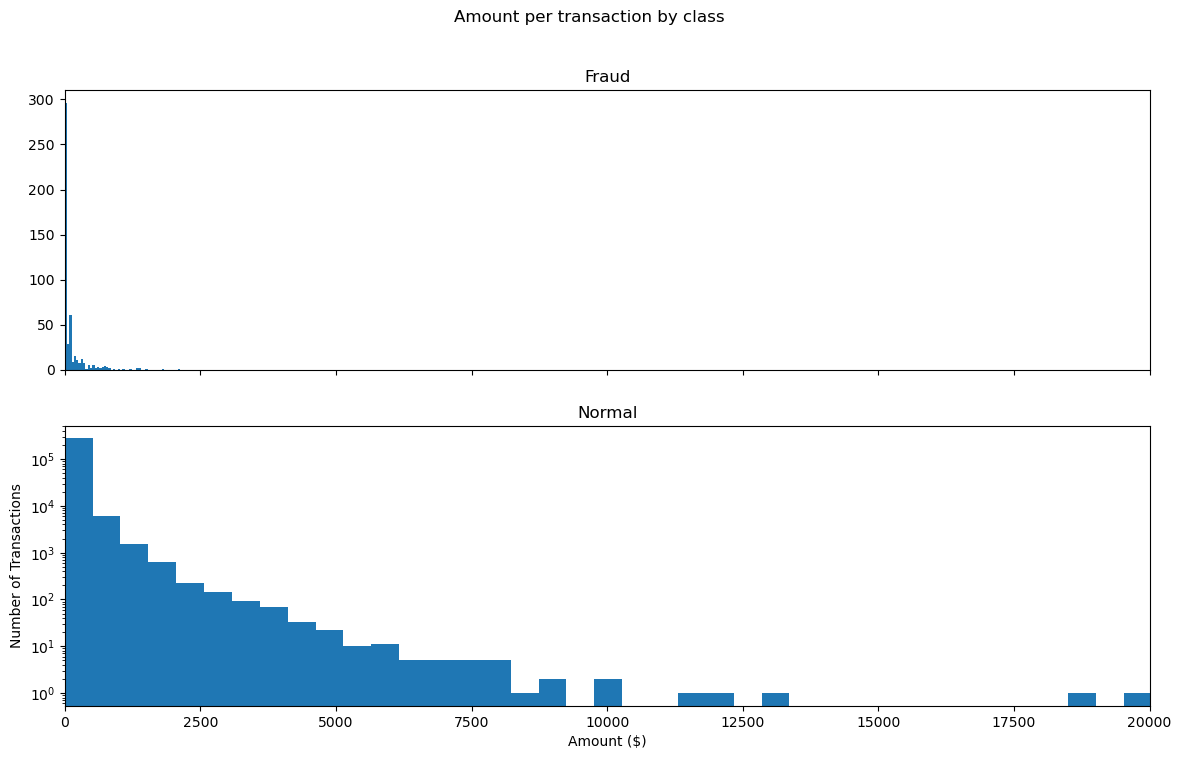

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

# creating independent and dependent features

In [14]:
columns = data1.columns.tolist()

#filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

#store the variable we are predecting
target = "Class"

#define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]

X_outliers = state.uniform(low=0 , high=1 ,size=(X.shape[0],X.shape[1]))

#print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


# # Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

In [26]:
#defining the outlier detection method

classifier = {
     "Isolation Forest": IsolationForest(n_estimators=100,max_samples=len(X),contamination=outlier_fraction,random_state=state,verbose=0)
} 

In [27]:
 type(classifier)

dict

In [31]:
n_outliers = len(fraud)

for i, (clf_name , clf) in enumerate(classifier.items()):
    #fit the data and tag outliers
    
    clf.fit(X)
    scores_prediction = clf.decision_function(X)
    y_pred = clf.predict(X)
    
    #reshape the prediction values to 0 for Valid transactions , 1 for fraud transaction
    
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    #Run Classification Matrics
    
    print("{} : {}".format(clf_name , n_errors))
    print("Accuracy Score:")
    print(accuracy_score(Y,y_pred))
    print("Classification Report : ")
    print(classification_report(Y,y_pred))

Isolation Forest : 75
Accuracy Score:
0.9973666654962958
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.24      0.24      0.24        49

    accuracy                           1.00     28481
   macro avg       0.62      0.62      0.62     28481
weighted avg       1.00      1.00      1.00     28481



# Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [37]:
      """       n_neighbors=20,            # Number of neighbors to consider
        algorithm='auto',           # Algorithm for nearest neighbors ('auto' selects the best)
        leaf_size=30,               # Leaf size for the tree (used with 'kd_tree' or 'ball_tree' algorithms)
        metric='minkowski',         # Distance metric for calculating nearest neighbors
        p=2,                        # Parameter for the Minkowski distance metric (p=2 for Euclidean distance)
        metric_params=None,         # Additional parameters for the chosen distance metric
        contamination=outlier_fraction  # Expected proportion of outliers in the dataset""" 

classifier2 = {
      "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)
} 

In [43]:
n_outliers = len(fraud)

for i, (clf_name , clf) in enumerate(classifier2.items()):
    #fit the data and tag outliers
    
    y_pred = clf.fit_predict(X)
    scores_prediction = clf.negative_outlier_factor_
    
    #reshape the prediction values to 0 for Valid transactions , 1 for fraud transaction
    
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    #Run Classification Matrics
    
    print("{} : {}".format(clf_name , n_errors))
    print("Accuracy Score:")
    print(accuracy_score(Y,y_pred))
    print("Classification Report : ")
    print(classification_report(Y,y_pred))

Local Outlier Factor : 97
Accuracy Score:
0.9965942207085425
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



# Support Vector Machine (SVM) for Outlier Detection:

SVM, typically used for classification, can also identify outliers in a one-class setting. Here's a concise overview:

One-Class SVM: SVM separates normal data from potential outliers by creating a decision boundary around the normal class.

Kernel Functions: It employs kernel functions to find nonlinear boundaries in data.

Margin and Support Vectors: SVM aims to maximize the margin (distance between the boundary and the nearest normal data points, called support vectors), making it less likely for outliers to be support vectors.

Nu Parameter: The nu parameter balances the margin size and the allowance for normal data misclassification. Lower nu values create larger margins but may misclassify some outliers.

Decision Function: SVM assigns decision scores to data points, with lower scores indicating proximity to the boundary and potential outlier status.

Thresholding: A threshold on decision scores can classify data points as outliers if their scores fall below it.

SVM-based outlier detection works well for high-dimensional or complex data distributions, but hyperparameter tuning and kernel selection are crucial. It's effective when normal data predominates and outliers are infrequent.

In [46]:
"""kernel='rbf',         # Radial Basis Function (RBF) kernel
        degree=3,             # Degree of the polynomial kernel (not used for RBF)
        gamma=0.1,            # Gamma parameter for the RBF kernel
        nu=0.05,              # Parameter controlling the trade-off between margin size and errors
        max_iter=-1           # Maximum number of iterations for the solver (-1 means no limit)"""

from sklearn.svm import OneClassSVM
classifier3 = {
     
    #"Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
     #                                    max_iter=-1, random_state=state)
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)
}

In [47]:
n_outliers = len(fraud)

for i, (clf_name , clf) in enumerate(classifier3.items()):
    #fit the data and tag outliers
    
    clf.fit(X)
    y_pred = clf.predict(X)
    
    #reshape the prediction values to 0 for Valid transactions , 1 for fraud transaction
    
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    #Run Classification Matrics
    
    print("{} : {}".format(clf_name , n_errors))
    print("Accuracy Score:")
    print(accuracy_score(Y,y_pred))
    print("Classification Report : ")
    print(classification_report(Y,y_pred))

Support Vector Machine : 8516
Accuracy Score:
0.7009936448860644
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     28432
           1       0.00      0.37      0.00        49

    accuracy                           0.70     28481
   macro avg       0.50      0.53      0.41     28481
weighted avg       1.00      0.70      0.82     28481

